In [10]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import lmfit
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import sympy

import matplotlib.lines as mlines

colorDic = {"blue" : "#6599FF", "yellow" : "#FFAD33",  "purple": "#683b96", "green" : "#198D6D", "red" : "#FF523F"}
colors = list(colorDic.values())

raycasts = ["IFRC", "FRC","HRC", "EFRC"]
OUTPUT_PATH = "./out/"

In [4]:
'''
Find intersection with infinite cylinder with center in the origin
to do that, translate the ray origin so that the center of the bottom base
is at the origin, then calculate intersection with the canonical infinite cylinder
and check if the ray intersects the lateral surface of the cylinder within our
bases, if not check if it's intersecting the bases and if not, it's not intersecting
our actual cylinder
'''
def calcCylinderIntersectValue (centerBottomBase, radius, rayOrigin, rayDirection):
    # translate the ray origin
    # Point 
    p0 = np.array([rayOrigin[0]-centerBottomBase[0], rayOrigin[1]-centerBottomBase[1], rayOrigin[2]-centerBottomBase[2]])
    # coefficients for the intersection equation
    # got them mathematically intersecting the line equation with the cylinder equation
    a = rayDirection[0] * rayDirection[0] + rayDirection[2] * rayDirection[2]
    b = rayDirection[0]*p0[0] +rayDirection[2]*p0[2]
    c = p0[0]*p0[0]+p0[2]*p0[2]-radius*radius
    delta = b*b - a*c

    #use epsilon because of computation errors between doubles
    epsilon = 0.00000001

    # delta < 0 means no intersections
    if (delta < epsilon):
        return (False, np.inf, np.inf)

    # nearest intersection
    t1 = (-b - np.sqrt (delta))/a
    t2 = (-b + np.sqrt (delta))/a
    return (True, t1, t2)

def calcCylinderIntersect (centerBottomBase, radius, rayOrigin, rayDirection):
    b, t1, t2 = calcCylinderIntersectValue(centerBottomBase, radius, rayOrigin, rayDirection)
    if (b):
        i1, i2 = (rayOrigin + rayDirection* t1, rayOrigin + rayDirection* t2)
        d1 = np.sqrt(np.sum(np.square(rayDirection- i1)))
        d2 = np.sqrt(np.sum(np.square(rayDirection- i2)))
        if (d1 < d2):
            return i1
        else:
            return i2
    else:
        return np.inf
    
def rotate3DAroundOrigin(point, pitch, yaw):
    x = point[:,0]
    y = point[:,1]
    z = point[:,2]
    r = np.sqrt(x*x + y*y + z*z)
    phi = np.arctan2(x,z)+np.deg2rad(yaw)
    theta = np.arccos(y/r)+np.deg2rad(pitch)
    x = r * np.sin( theta ) * np.sin( phi )
    y = r * np.cos( theta )
    z = r * np.sin( theta ) * np.cos( phi )
    
    
    return np.array([x,y,z]).T

def getOrientaion(points):
    x = points[:,0]
    y = points[:,1]
    z = points[:,2]
    r = np.sqrt(x*x + y*y + z*z)
    phi = np.arctan2(x,z)
    theta = np.arccos(y/r)
    return np.array([np.rad2deg(theta), np.rad2deg(phi)]).T
    
    #yaw = np.arctan2(points[:,0], points[:,2])
    #pitch = np.arctan2(np.sqrt((points[:,0] * points[:,0]) + (points[:,1] * points[:,1])), points[:,2]);
    #return np.array([np.rad2deg(pitch), np.rad2deg(yaw)]).T

points = np.array([[1,1,0], [1,-1,0], [1,99,0], [1,-99,0],[1,1,1], [5, 5,5], [-5, -5,-5]])
getOrientaion(points)

array([[  45.        ,   90.        ],
       [ 135.        ,   90.        ],
       [   0.57872557,   90.        ],
       [ 179.42127443,   90.        ],
       [  54.73561032,   45.        ],
       [  54.73561032,   45.        ],
       [ 125.26438968, -135.        ]])

In [5]:
dfPointer = pd.read_pickle(OUTPUT_PATH + "data_v03_PointerOnly.pkl")
len(dfPointer)

3360

In [6]:
from mpmath import mp
def funSin2(params, pitch, yaw):
    
    ampPitch = params['ampPitch']
    pshiftPitch = params['phasePitch']
    freqPitch = params['frequencyPitch']
    offsetPitch = params['offsetPitch']
    
    ampYaw = params['ampYaw']
    pshiftYaw = params['phaseYaw']
    freqYaw = params['frequencyYaw']
    offsetYaw = params['offsetYaw']
    return ((ampYaw * np.sin(freqYaw.value * (yaw - pshiftYaw.value)) + offsetYaw.value)+1) * ((ampPitch * np.sin(freqPitch.value * (pitch - pshiftPitch.value)) + offsetPitch.value)+1)

def residualSin2(params, pitch, yaw, error):
    global iterCount
    val = funSin2(params, pitch, yaw)
    rmse = np.sqrt(sklearn.metrics.mean_squared_error(error,   val))
    #print ("Iter: %i: %.2f, %.2f, %.2f, %.2f, %.2f, %.2f, %.2f, %.2f, Error: %.9f" % (iterCount, params['ampYaw'], params['phaseYaw'], params['frequencyYaw'], params['offsetYaw'],                                                                                      params['ampPitch'], params['phasePitch'], params['frequencyPitch'], params['offsetPitch'], rmse))
    iterCount = iterCount+1
    return val-error

def predictSin2 (pitch, yaw, error):
    global iterCount
    iterCount = 0
    params = lmfit.Parameters()
    params.add('ampPitch', value=0)#, min=-2*np.pi/180, max = 2*np.pi/180)
    params.add('phasePitch', value=0)#,  min=0, max = 2*np.pi/180*2)
    params.add('frequencyPitch', value=1, min=0.5, max =  4*np.pi)
    params.add('offsetPitch', value=np.mean(pitch))
    
    params.add('ampYaw', value=0)#, min=-2*np.pi/180, max = 2*np.pi/180)
    params.add('phaseYaw', value=0)#,  min=0, max = 2*np.pi/180*2)
    params.add('frequencyYaw', value=1, vary=False)
    params.add('offsetYaw', value=np.mean(yaw))
    
    minfit = lmfit.Minimizer(residualSin2, params, fcn_args=(pitch, yaw, error), reduce_fcn='neglogcauchy')
    out1 = minfit.minimize(method='Nelder')
    return minfit.minimize(method='leastsq', params=out1.params)


In [213]:
%%time
outPitch = predictSin2(np.deg2rad(dfPointer.IFRCPitch), np.deg2rad(dfPointer.IFRCYaw), dfPointer.IFRCPitchError)
outYaw   = predictSin2(np.deg2rad(dfPointer.IFRCPitch), np.deg2rad(dfPointer.IFRCYaw), dfPointer.IFRCYawError)
predPitch = funSin2(outPitch.params,  np.deg2rad(dfPointer.IFRCPitch), np.deg2rad(dfPointer.IFRCYaw))
predYaw   = funSin2(outYaw.params, np.deg2rad(dfPointer.IFRCPitch), np.deg2rad(dfPointer.IFRCYaw))
rsquarePitch = sklearn.metrics.r2_score(dfPointer.IFRCPitchError, predPitch)
rsquareYaw   = sklearn.metrics.r2_score(dfPointer.IFRCYawError,   predYaw)
print('   R2   Pitch: ' + str(rsquarePitch))
print('   R2   Yaw  : ' + str(rsquareYaw))
rmsePitch = np.sqrt(sklearn.metrics.mean_squared_error(dfPointer.IFRCPitchError, predPitch))
rmseYaw   = np.sqrt(sklearn.metrics.mean_squared_error(dfPointer.IFRCYawError,   predYaw))

print('   RMSE  Pitch: ' + str(rmsePitch))
print('   Error Pitch: ' + str((dfPointer.IFRCPitchError-predYaw).mean()) + '  SD: ' + str((dfPointer.IFRCPitchError-predYaw).std()))
print('   RMSE  Yaw  : ' + str(rmseYaw))
print('   Error Yaw  : ' + str((dfPointer.IFRCYawError-predYaw).mean()) + '  SD: ' + str((dfPointer.IFRCYawError-predYaw).std()))

print('   Reduction Pitch: %.2f' % ((1-((dfPointer.IFRCPitchError-predPitch).abs().mean()/dfPointer.IFRCPitchError.abs().mean()))*100))
print('   Reduction Yaw:   %.2f' % ((1-((dfPointer.IFRCYawError-predYaw).abs().mean()/dfPointer.IFRCYawError.abs().mean()))*100))

   R2   Pitch: 0.21131660820522535
   R2   Yaw  : 0.02340097218646009
   RMSE  Pitch: 7.419106789712207
   Error Pitch: -6.136617314607138  SD: 8.18379796099067
   RMSE  Yaw  : 10.717116712950174
   Error Yaw  : -0.001407825480383908  SD: 10.718711785575927
   Reduction Pitch: 63.24
   Reduction Yaw:   43.15
CPU times: user 47.5 s, sys: 9.28 ms, total: 47.5 s
Wall time: 47.5 s


Parameters([('ampPitch', <Parameter 'ampPitch', value=-0.192981770820865 +/- 4.99e+04, bounds=[-inf:inf]>), ('phasePitch', <Parameter 'phasePitch', value=-1.5398063630198164 +/- 1.22, bounds=[-inf:inf]>), ('frequencyPitch', <Parameter 'frequencyPitch', value=1.00004316151353 +/- 0.434, bounds=[1:6.283185307179586]>), ('offsetPitch', <Parameter 'offsetPitch', value=-1.155881753267239 +/- 4.03e+04, bounds=[-inf:inf]>), ('ampYaw', <Parameter 'ampYaw', value=-1.9334176718216958 +/- 5e+05, bounds=[-inf:inf]>), ('phaseYaw', <Parameter 'phaseYaw', value=-3.4448802254941233 +/- 0.447, bounds=[-inf:inf]>), ('frequencyYaw', <Parameter 'frequencyYaw', value=1 (fixed), bounds=[-inf:inf]>), ('offsetYaw', <Parameter 'offsetYaw', value=68.53065530191292 +/- 1.8e+07, bounds=[-inf:inf]>)])
Parameters([('ampPitch', <Parameter 'ampPitch', value=-38.9266576750861 +/- nan, bounds=[-inf:inf]>), ('phasePitch', <Parameter 'phasePitch', value=141.20638101155288 +/- 278, bounds=[-inf:inf]>), ('frequencyPitch', 

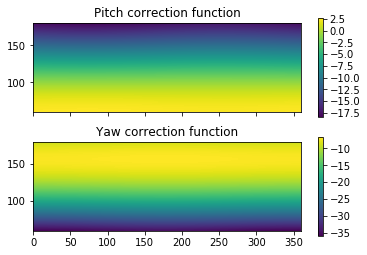

In [214]:
print(outPitch.params)
print(outYaw.params)

pitch = np.linspace(60,180,181)
yaw = np.linspace(0,360,361)

# filling the heatmap, value by value
fun_map = np.empty((pitch.size, yaw.size))
for y in range (yaw.size):
    for p in range (pitch.size):
        fun_map[p,y] = funSin2(outPitch.params, np.deg2rad(pitch[p]), np.deg2rad(yaw[y]))
        
f, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.set_title('Pitch correction function')
im = ax1.imshow(fun_map,extent=(yaw[0], yaw[-1], pitch[0], pitch[-1]))
f.colorbar(im, ax=ax1)

# filling the heatmap, value by value
fun_map = np.empty((pitch.size, yaw.size))
for y in range (yaw.size):
    for p in range (pitch.size):
        fun_map[p,y] = funSin2(outYaw.params, np.deg2rad(pitch[p]), np.deg2rad(yaw[y]))
#s = fig.add_subplot(1, 1, 1, xlabel='$Yaw$', ylabel='$Pitch$')
ax2.set_title('Yaw correction function')
im = ax2.imshow(fun_map,extent=(yaw[0], yaw[-1], pitch[0], pitch[-1]))
f.colorbar(im, ax=ax2)
plt.show()
plt.show()

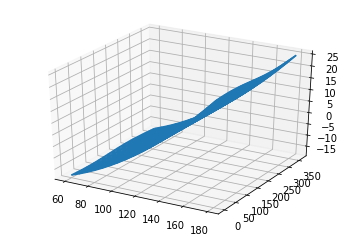

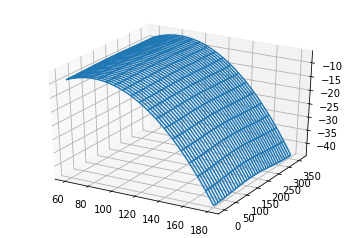

In [199]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Grab some test data.
X, Y = np.meshgrid(pitch,yaw)
Z = funSin2(outPitch.params, np.deg2rad(X), np.deg2rad(Y))

# Plot a basic wireframe.
ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Grab some test data.
X, Y = np.meshgrid(pitch,yaw)
Z = funSin2(outYaw.params, np.deg2rad(X), np.deg2rad(Y))

# Plot a basic wireframe.
ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)

In [158]:
outPitch = predictSin2(np.deg2rad(dfPointer.FRCPitch), np.deg2rad(dfPointer.FRCYaw), dfPointer.FRCPitchError)
outYaw   = predictSin2(np.deg2rad(dfPointer.FRCPitch), np.deg2rad(dfPointer.FRCYaw), dfPointer.FRCYawError)
predPitch = funSin2(outPitch.params,  np.deg2rad(dfPointer.FRCPitch), np.deg2rad(dfPointer.FRCYaw))
predYaw   = funSin2(outYaw.params, np.deg2rad(dfPointer.FRCPitch), np.deg2rad(dfPointer.FRCYaw))
rsquarePitch = sklearn.metrics.r2_score(dfPointer.FRCPitchError, predPitch)
rsquareYaw   = sklearn.metrics.r2_score(dfPointer.FRCYawError,   predYaw)
print('   R2   Pitch: ' + str(rsquarePitch))
print('   R2   Yaw  : ' + str(rsquareYaw))
rmsePitch = np.sqrt(sklearn.metrics.mean_squared_error(dfPointer.FRCPitchError, predPitch))
rmseYaw   = np.sqrt(sklearn.metrics.mean_squared_error(dfPointer.FRCYawError,   predYaw))

print('   RMSE  Pitch: ' + str(rmsePitch))
print('   Error Pitch: ' + str((dfPointer.FRCPitchError-predYaw).mean()) + '  SD: ' + str((dfPointer.FRCPitchError-predYaw).std()))
print('   RMSE  Yaw  : ' + str(rmseYaw))
print('   Error Yaw  : ' + str((dfPointer.FRCYawError-predYaw).mean()) + '  SD: ' + str((dfPointer.FRCYawError-predYaw).std()))

print('   Reduction Pitch: %.2f' % ((1-((dfPointer.FRCPitchError-predPitch).abs().mean()/dfPointer.FRCPitchError.abs().mean()))*100))
print('   Reduction Yaw:   %.2f' % ((1-((dfPointer.FRCYawError-predYaw).abs().mean()/dfPointer.FRCYawError.abs().mean()))*100))

   R2   Pitch: 0.09598847902043628
   R2   Yaw  : 0.030755529966377093
   RMSE  Pitch: 9.144622380620747
   Error Pitch: 15.50643174123581  SD: 9.983571998954496
   RMSE  Yaw  : 14.165197229898686
   Error Yaw  : 0.0006178655505133672  SD: 14.167305603309673
   Reduction Pitch: 52.84
   Reduction Yaw:   67.12


In [159]:
outPitch = predictSin2(np.deg2rad(dfPointer.HRCPitch), np.deg2rad(dfPointer.HRCYaw), dfPointer.HRCPitchError)
outYaw   = predictSin2(np.deg2rad(dfPointer.HRCPitch), np.deg2rad(dfPointer.HRCYaw), dfPointer.HRCYawError)
predPitch = funSin2(outPitch.params,  np.deg2rad(dfPointer.HRCPitch), np.deg2rad(dfPointer.HRCYaw))
predYaw   = funSin2(outYaw.params, np.deg2rad(dfPointer.HRCPitch), np.deg2rad(dfPointer.HRCYaw))
rsquarePitch = sklearn.metrics.r2_score(dfPointer.HRCPitchError, predPitch)
rsquareYaw   = sklearn.metrics.r2_score(dfPointer.HRCYawError,   predYaw)
print('   R2   Pitch: ' + str(rsquarePitch))
print('   R2   Yaw  : ' + str(rsquareYaw))
rmsePitch = np.sqrt(sklearn.metrics.mean_squared_error(dfPointer.HRCPitchError, predPitch))
rmseYaw   = np.sqrt(sklearn.metrics.mean_squared_error(dfPointer.HRCYawError,   predYaw))

print('   RMSE  Pitch: ' + str(rmsePitch))
print('   Error Pitch: ' + str((dfPointer.HRCPitchError-predYaw).mean()) + '  SD: ' + str((dfPointer.HRCPitchError-predYaw).std()))
print('   RMSE  Yaw  : ' + str(rmseYaw))
print('   Error Yaw  : ' + str((dfPointer.HRCYawError-predYaw).mean()) + '  SD: ' + str((dfPointer.HRCYawError-predYaw).std()))

print('   Reduction Pitch: %.2f' % ((1-((dfPointer.HRCPitchError-predPitch).abs().mean()/dfPointer.HRCPitchError.abs().mean()))*100))
print('   Reduction Yaw:   %.2f' % ((1-((dfPointer.HRCYawError-predYaw).abs().mean()/dfPointer.HRCYawError.abs().mean()))*100))

   R2   Pitch: 0.046388909718275584
   R2   Yaw  : 0.0033343181715839165
   RMSE  Pitch: 10.029862635759786
   Error Pitch: 7.953671125254687  SD: 10.29177855882365
   RMSE  Yaw  : 10.96240811830408
   Error Yaw  : 0.0014271123949042488  SD: 10.964039700351892
   Reduction Pitch: 6.50
   Reduction Yaw:   18.25


In [16]:
outPitch = predictSin2(np.deg2rad(dfPointer.EFRCPitch), np.deg2rad(dfPointer.EFRCYaw), dfPointer.EFRCPitchError)
outYaw   = predictSin2(np.deg2rad(dfPointer.EFRCPitch), np.deg2rad(dfPointer.EFRCYaw), dfPointer.EFRCYawError)
predPitch = funSin2(outPitch.params,  np.deg2rad(dfPointer.EFRCPitch), np.deg2rad(dfPointer.EFRCYaw))
predYaw   = funSin2(outYaw.params, np.deg2rad(dfPointer.EFRCPitch), np.deg2rad(dfPointer.EFRCYaw))
rsquarePitch = sklearn.metrics.r2_score(dfPointer.EFRCPitchError, predPitch)
rsquareYaw   = sklearn.metrics.r2_score(dfPointer.EFRCYawError,   predYaw)
print('   R2   Pitch: ' + str(rsquarePitch))
print('   R2   Yaw  : ' + str(rsquareYaw))
rmsePitch = np.sqrt(sklearn.metrics.mean_squared_error(dfPointer.EFRCPitchError, predPitch))
rmseYaw   = np.sqrt(sklearn.metrics.mean_squared_error(dfPointer.EFRCYawError,   predYaw))

print('   RMSE  Pitch: ' + str(rmsePitch))
print('   Error Pitch: ' + str((dfPointer.EFRCPitchError-predYaw).mean()) + '  SD: ' + str((dfPointer.EFRCPitchError-predYaw).std()))
print('   RMSE  Yaw  : ' + str(rmseYaw))
print('   Error Yaw  : ' + str((dfPointer.EFRCYawError-predYaw).mean()) + '  SD: ' + str((dfPointer.EFRCYawError-predYaw).std()))

print('   Reduction Pitch: %.2f' % ((1-((dfPointer.EFRCPitchError-predPitch).abs().mean()/dfPointer.EFRCPitchError.abs().mean()))*100))
print('   Reduction Yaw:   %.2f' % ((1-((dfPointer.EFRCYawError-predYaw).abs().mean()/dfPointer.EFRCYawError.abs().mean()))*100))

   R2   Pitch: 0.0010969954308157615
   R2   Yaw  : 0.017902712536573828
   RMSE  Pitch: 2.9801856080960962
   Error Pitch: -0.314207705690925  SD: 2.666925294709399
   RMSE  Yaw  : 7.862984488897352
   Error Yaw  : 0.07944886286137996  SD: 7.86375338507113
   Reduction Pitch: 2.61
   Reduction Yaw:   12.73


In [204]:
outPitch = predictSin2(np.deg2rad(dfPointer.EFRCPitch), np.deg2rad(dfPointer.EFRCYaw), dfPointer.EFRCPitchError)
outYaw   = predictSin2(np.deg2rad(dfPointer.EFRCPitch), np.deg2rad(dfPointer.EFRCYaw), dfPointer.EFRCYawError)
predPitch = funSin2(outPitch.params,  np.deg2rad(dfPointer.EFRCPitch), np.deg2rad(dfPointer.EFRCYaw))
predYaw   = funSin2(outYaw.params, np.deg2rad(dfPointer.EFRCPitch), np.deg2rad(dfPointer.EFRCYaw))
rsquarePitch = sklearn.metrics.r2_score(dfPointer.EFRCPitchError, predPitch)
rsquareYaw   = sklearn.metrics.r2_score(dfPointer.EFRCYawError,   predYaw)
print('   R2   Pitch: ' + str(rsquarePitch))
print('   R2   Yaw  : ' + str(rsquareYaw))
rmsePitch = np.sqrt(sklearn.metrics.mean_squared_error(dfPointer.EFRCPitchError, predPitch))
rmseYaw   = np.sqrt(sklearn.metrics.mean_squared_error(dfPointer.EFRCYawError,   predYaw))

print('   RMSE  Pitch: ' + str(rmsePitch))
print('   Error Pitch: ' + str((dfPointer.EFRCPitchError-predYaw).mean()) + '  SD: ' + str((dfPointer.EFRCPitchError-predYaw).std()))
print('   RMSE  Yaw  : ' + str(rmseYaw))
print('   Error Yaw  : ' + str((dfPointer.EFRCYawError-predYaw).mean()) + '  SD: ' + str((dfPointer.EFRCYawError-predYaw).std()))

print('   Reduction Pitch: %.2f' % ((1-((dfPointer.EFRCPitchError-predPitch).abs().mean()/dfPointer.EFRCPitchError.abs().mean()))*100))
print('   Reduction Yaw:   %.2f' % ((1-((dfPointer.EFRCYawError-predYaw).abs().mean()/dfPointer.EFRCYawError.abs().mean()))*100))

   R2   Pitch: 0.002809217577975809
   R2   Yaw  : 0.016197803204310968
   RMSE  Pitch: 2.9776303408137177
   Error Pitch: -0.3166162639169273  SD: 2.7052007458152616
   RMSE  Yaw  : 7.869806553689896
   Error Yaw  : 0.0770403046353776  SD: 7.870600764843636
   Reduction Pitch: 3.56
   Reduction Yaw:   12.75


Parameters([('ampPitch', <Parameter 'ampPitch', value=-0.10635681928768677 +/- 7.38e+04, bounds=[-inf:inf]>), ('phasePitch', <Parameter 'phasePitch', value=-1304.5539050640202 +/- 308, bounds=[-inf:inf]>), ('frequencyPitch', <Parameter 'frequencyPitch', value=9.64851951872593 +/- 2.31, bounds=[0.5:12.566370614359172]>), ('offsetPitch', <Parameter 'offsetPitch', value=-0.2746418725040505 +/- 5.03e+05, bounds=[-inf:inf]>), ('ampYaw', <Parameter 'ampYaw', value=-0.08058825616644799 +/- 5.59e+04, bounds=[-inf:inf]>), ('phaseYaw', <Parameter 'phaseYaw', value=-119.7374879176057 +/- 1.29, bounds=[-inf:inf]>), ('frequencyYaw', <Parameter 'frequencyYaw', value=1 (fixed), bounds=[-inf:inf]>), ('offsetYaw', <Parameter 'offsetYaw', value=0.22772971138352577 +/- 8.51e+05, bounds=[-inf:inf]>)])
Parameters([('ampPitch', <Parameter 'ampPitch', value=-1.863992200124066 +/- 1.63e+05, bounds=[-inf:inf]>), ('phasePitch', <Parameter 'phasePitch', value=-1.5327855490377444 +/- 11.7, bounds=[-inf:inf]>), ('

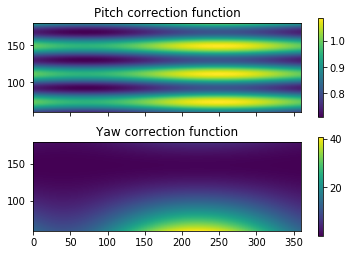

In [17]:
print(outPitch.params)
print(outYaw.params)

pitch = np.linspace(60,180,181)
yaw = np.linspace(0,360,361)

# filling the heatmap, value by value
fun_map = np.empty((pitch.size, yaw.size))
for y in range (yaw.size):
    for p in range (pitch.size):
        fun_map[p,y] = funSin2(outPitch.params, np.deg2rad(pitch[p]), np.deg2rad(yaw[y]))
        
f, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.set_title('Pitch correction function')
im = ax1.imshow(fun_map,extent=(yaw[0], yaw[-1], pitch[0], pitch[-1]))
f.colorbar(im, ax=ax1)

# filling the heatmap, value by value
fun_map = np.empty((pitch.size, yaw.size))
for y in range (yaw.size):
    for p in range (pitch.size):
        fun_map[p,y] = funSin2(outYaw.params, np.deg2rad(pitch[p]), np.deg2rad(yaw[y]))
#s = fig.add_subplot(1, 1, 1, xlabel='$Yaw$', ylabel='$Pitch$')
ax2.set_title('Yaw correction function')
im = ax2.imshow(fun_map,extent=(yaw[0], yaw[-1], pitch[0], pitch[-1]))
f.colorbar(im, ax=ax2)
plt.show()
plt.show()

Parameters([('ampPitch', <Parameter 'ampPitch', value=-0.04880050381036766 +/- 1.25e+05, bounds=[-inf:inf]>), ('phasePitch', <Parameter 'phasePitch', value=25263.514490964928 +/- 202, bounds=[-inf:inf]>), ('frequencyPitch', <Parameter 'frequencyPitch', value=2.560970642411153 +/- 4.38, bounds=[1:6.283185307179586]>), ('offsetPitch', <Parameter 'offsetPitch', value=-0.2899441812362762 +/- 3.82e+05, bounds=[-inf:inf]>), ('ampYaw', <Parameter 'ampYaw', value=-0.02079418845404986 +/- 5.91e+04, bounds=[-inf:inf]>), ('phaseYaw', <Parameter 'phaseYaw', value=95.48068751662016 +/- 1.26, bounds=[-inf:inf]>), ('frequencyYaw', <Parameter 'frequencyYaw', value=1 (fixed), bounds=[-inf:inf]>), ('offsetYaw', <Parameter 'offsetYaw', value=0.20946306018843788 +/- 6.7e+05, bounds=[-inf:inf]>)])
Parameters([('ampPitch', <Parameter 'ampPitch', value=-0.7390442097009482 +/- 2.61e+05, bounds=[-inf:inf]>), ('phasePitch', <Parameter 'phasePitch', value=0.03966286990728794 +/- 1.53, bounds=[-inf:inf]>), ('freq

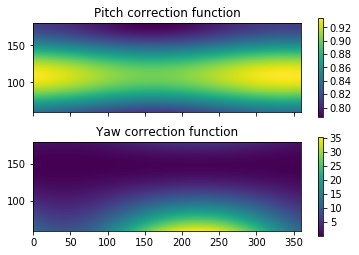

In [212]:
print(outPitch.params)
print(outYaw.params)

pitch = np.linspace(60,180,181)
yaw = np.linspace(0,360,361)

# filling the heatmap, value by value
fun_map = np.empty((pitch.size, yaw.size))
for y in range (yaw.size):
    for p in range (pitch.size):
        fun_map[p,y] = funSin2(outPitch.params, np.deg2rad(pitch[p]), np.deg2rad(yaw[y]))
        
f, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.set_title('Pitch correction function')
im = ax1.imshow(fun_map,extent=(yaw[0], yaw[-1], pitch[0], pitch[-1]))
f.colorbar(im, ax=ax1)

# filling the heatmap, value by value
fun_map = np.empty((pitch.size, yaw.size))
for y in range (yaw.size):
    for p in range (pitch.size):
        fun_map[p,y] = funSin2(outYaw.params, np.deg2rad(pitch[p]), np.deg2rad(yaw[y]))
#s = fig.add_subplot(1, 1, 1, xlabel='$Yaw$', ylabel='$Pitch$')
ax2.set_title('Yaw correction function')
im = ax2.imshow(fun_map,extent=(yaw[0], yaw[-1], pitch[0], pitch[-1]))
f.colorbar(im, ax=ax2)
plt.show()
plt.show()

In [202]:
list(outYaw.params.values())

[<Parameter 'ampPitch', value=-1.1673115694525 +/- nan, bounds=[-inf:inf]>,
 <Parameter 'phasePitch', value=-17.651898597906168 +/- 2.65e+03, bounds=[-inf:inf]>,
 <Parameter 'frequencyPitch', value=0.08155604659875652 +/- 11.3, bounds=[0:6.283185307179586]>,
 <Parameter 'offsetPitch', value=0.16741989589634218 +/- nan, bounds=[-inf:inf]>,
 <Parameter 'ampYaw', value=-1710.8301816583385 +/- nan, bounds=[-inf:inf]>,
 <Parameter 'phaseYaw', value=-69.98432183581143 +/- 0.235, bounds=[-inf:inf]>,
 <Parameter 'frequencyYaw', value=1 (fixed), bounds=[-inf:inf]>,
 <Parameter 'offsetYaw', value=2920.066204937139 +/- nan, bounds=[-inf:inf]>]

In [21]:

pitch = sympy.Symbol('pitch')
yaw = sympy.Symbol('yaw')

ampPitch = sympy.Symbol('ampPitch')
freqPitch = sympy.Symbol('freqPitch')
pshiftPitch = sympy.Symbol('pshiftPitch')
offsetPitch = sympy.Symbol('offsetPitch')
ampYaw = sympy.Symbol('ampYaw')
freqYaw = sympy.Symbol('freqYaw')
pshiftYaw = sympy.Symbol('pshiftYaw')
offsetYaw = sympy.Symbol('offsetYaw')


z = ((ampYaw * sympy.sin(freqYaw * (yaw - pshiftYaw)) + offsetYaw)+1) * ((ampPitch * sympy.sin(freqPitch * (pitch - pshiftPitch)) + offsetPitch)+1)
z = sympy.expand(z)
z

-ampPitch*ampYaw*sin(freqPitch*pitch - freqPitch*pshiftPitch)*sin(freqYaw*pshiftYaw - freqYaw*yaw) + ampPitch*offsetYaw*sin(freqPitch*pitch - freqPitch*pshiftPitch) + ampPitch*sin(freqPitch*pitch - freqPitch*pshiftPitch) - ampYaw*offsetPitch*sin(freqYaw*pshiftYaw - freqYaw*yaw) - ampYaw*sin(freqYaw*pshiftYaw - freqYaw*yaw) + offsetPitch*offsetYaw + offsetPitch + offsetYaw + 1